# Garbage Detection

In [31]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import zipfile
import os
from imutils import paths
import argparse
from sklearn.preprocessing import LabelBinarizer
import keras.api._v2.keras as keras
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.applications import MobileNetV2, ResNet101
from tensorflow.keras.layers import Dropout, Conv2D, Flatten, Dense, Input,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
import cv2

### References

https://pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/

https://shreyash1811.github.io/python/Garbage_classification/

## Dataset
We're using Trashnet. 
Found here: https://github.com/garythung/trashnet

In [32]:
# import dataset
zip_ref = zipfile.ZipFile('dataset-resized.zip', 'r') #r stands for read mode
zip_ref.extractall('/tmp') 
zip_ref.close()
os.remove('/tmp/dataset-resized/.DS_Store')

In [33]:
len(os.listdir('/tmp/dataset-resized/trash/')) # testing dataset to make sure conneted

137

In [34]:
#Variables
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [35]:
# loop over the image paths and append to arrays
data = []
label = []
imagePath = os.listdir('/tmp/dataset-resized')
for directoryPath in imagePath:
  path = os.path.join('/tmp/dataset-resized',directoryPath)
  for img in os.listdir(path):
    labelImage = directoryPath
    image = load_img(os.path.join(path,img), target_size=(300, 300))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    label.append(labelImage)

In [36]:
train_generator = ImageDataGenerator(
    rescale=1./255,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")
validate_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_data = train_generator.flow_from_directory(
    directory= '/tmp/dataset-resized',
    target_size=(300,300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)
validation_data = validate_generator.flow_from_directory(
    directory= '/tmp/dataset-resized',
    target_size=(300,300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)
label = (train_data.class_indices)

Found 2527 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [37]:
base= MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(300,300, 3)), input_shape = (300,300, 3))

In [38]:
#  make the head
inputs = Input(shape=(300,300,3))
# extra convolution layers to fine-tune the network
head = base.output
head  = Conv2D(32,3,padding='same',  activation='relu', input_shape = (300,300, 3))(head)
head = MaxPooling2D((2,2), padding='same')(head)
head  = Conv2D(64,3,padding='same',  activation='relu', input_shape = (300,300, 3))(head)
head = MaxPooling2D((2,2), padding='same')(head)
head  = Conv2D(32,3,padding='same',  activation='relu', input_shape = (300,300, 3))(head)
head = MaxPooling2D((2,2), padding='same')(head)
head = Flatten()(head)
head = Dense(64, activation="relu")(head)
head = Dense(6, activation="softmax")(head)

In [39]:
model = Model(inputs=base.inputs, outputs=head)

In [41]:
print("[INFO] compiling model...")
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

#validates ad correct behaviours

checkpoints = ModelCheckpoint(
    filepath='models',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

early_stop = EarlyStopping(monitor='loss', patience=3)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

[INFO] compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                 

In [42]:

# train the head of the network
print("[INFO] training head...")
garbageModel = model.fit(
    train_data,
    validation_data = validation_data,
    epochs=15,
    batch_size=16, 
    callbacks=[reduce, checkpoints, early_stop]
)

[INFO] training head...
Epoch 1/15
158/158 [==============================] - ETA: 0s - loss: 1.5581 - accuracy: 0.4155

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


158/158 [==============================] - 1003s 6s/step - loss: 1.5581 - accuracy: 0.4155 - val_loss: 1.7846 - val_accuracy: 0.2107 - lr: 0.0010
Epoch 2/15
158/158 [==============================] - 923s 6s/step - loss: 1.2615 - accuracy: 0.5311 - val_loss: 3.5979 - val_accuracy: 0.2406 - lr: 0.0010
Epoch 3/15
158/158 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.5568
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
158/158 [==============================] - 1038s 7s/step - loss: 1.1582 - accuracy: 0.5568 - val_loss: 3.5768 - val_accuracy: 0.2346 - lr: 0.0010
Epoch 4/15
158/158 [==============================] - 968s 6s/step - loss: 0.9591 - accuracy: 0.6324 - val_loss: 4.3845 - val_accuracy: 0.2366 - lr: 1.0000e-04
Epoch 5/15
158/158 [==============================] - ETA: 0s - loss: 0.8433 - accuracy: 0.6727
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
158/158 [==============================] - 845

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


158/158 [==============================] - 840s 5s/step - loss: 0.7451 - accuracy: 0.7091 - val_loss: 1.6177 - val_accuracy: 0.4970 - lr: 1.0000e-05
Epoch 11/15
158/158 [==============================] - ETA: 0s - loss: 0.7318 - accuracy: 0.7198

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


158/158 [==============================] - 917s 6s/step - loss: 0.7318 - accuracy: 0.7198 - val_loss: 1.3891 - val_accuracy: 0.5348 - lr: 1.0000e-05
Epoch 12/15
158/158 [==============================] - ETA: 0s - loss: 0.7404 - accuracy: 0.7269

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


158/158 [==============================] - 951s 6s/step - loss: 0.7404 - accuracy: 0.7269 - val_loss: 1.2039 - val_accuracy: 0.5626 - lr: 1.0000e-05
Epoch 13/15
158/158 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.7147

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


158/158 [==============================] - 847s 5s/step - loss: 0.7446 - accuracy: 0.7147 - val_loss: 1.0816 - val_accuracy: 0.5885 - lr: 1.0000e-05
Epoch 14/15
158/158 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.7230

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


158/158 [==============================] - 815s 5s/step - loss: 0.7281 - accuracy: 0.7230 - val_loss: 1.0014 - val_accuracy: 0.6163 - lr: 1.0000e-05
Epoch 15/15
158/158 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.7218

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


158/158 [==============================] - 863s 5s/step - loss: 0.7421 - accuracy: 0.7218 - val_loss: 0.9107 - val_accuracy: 0.6322 - lr: 1.0000e-05


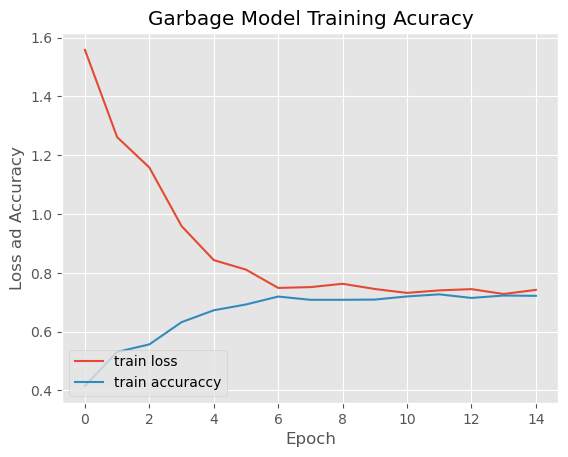

In [43]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), garbageModel.history["loss"], label="train loss")
plt.plot(np.arange(0, 15), garbageModel.history["accuracy"], label="train accuraccy")
plt.title("Garbage Model Training Acuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss ad Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

In [49]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


-batch sizes
-optomizer: could use rms prop
-tune hyperparameters 
-calllbacks? Early stopping, model checkpoint, tensorborad , reduceRonplateu
-callbacks after compile but before fit
-stratify
-adding that thing so everytime some layer doesn't change?